### BBDataCon Week


<p><b>Predição preço de ações utilizando LSTM.</b></p>

<ol font-size=7x>O workshop será divido em:
    <li>Acesso à Plataforma Analítica;</li>
    <li>Introdução a Redes Neurais Artificiais;</li>
    <li>Introdução à LSTM;</li>
    <li>Cosntrução de modelo preditivo.</li>
</ol>



#### Introdução a Redes Neurais

<p>Chamamos de Redes Neurais Artificiais, ou apenas Redes Neurais, os sistemas que são inspirados no funcionamento do sistema nervoso central.</p>
<p>Foram concebidas para emular o funcionamento da memória associativa, ou seja, reconhecem padrões nas observações, podendo clusterizar, classificar e estimar valores futuros. </p>
Quando usamos Redes Neurais em processo de aprendizado, o chamado <i>Deep Learning</i>, construímos as redes com um conjunto de <i>layers</i> (camadas), onde cada <i>layer</i> é composta por um conjunto de <i>nodes</i> (nós). 

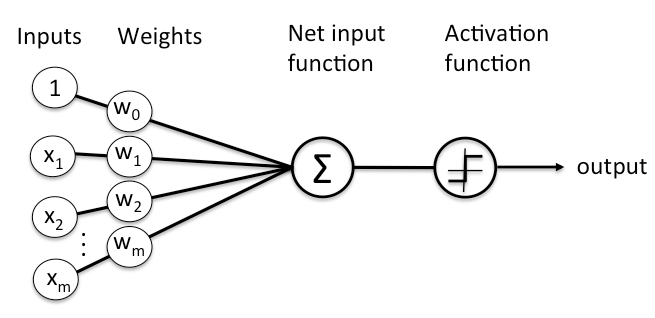

Fonte: https://pathmind.com/wiki/neural-network

<p>Logo, quando temos múltiplas camadas, a saída de uma se torna o <i>input</i> da próxima. 
</p>


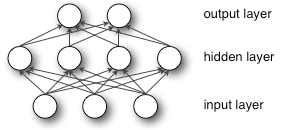

Fonte: https://pathmind.com/wiki/neural-network

 #### LSTM

Existem vários tipos de de Redes Neurais, nosso objetivo é entender o funionamento das redes LSTM, que são uma variação das Redes Neurais Recorrentes (RNN).
As RNN permitem que a durante o processo de aprendizado a rede use o os dados de <i>input</i> em conjunto com os valores de saída obtidas nos passos anteriores que permitem que os erros gerados no processo de estimação possam ser retropropagadas através do tempo e das camadas da rede. Essa característica permite que possamos manter um link de causa e efeito entre observações distantes no tempo. Isto é, possuem um loop de retroalimentação usando os resultados passados como <i>input</i>.
<p> Devido ao processo de retroalimentação, as RNN podem sofrer com problemas de convergência. Para solucionar esse problema, foram criadas as redes LSTMs, que são capazes de manter a informação fora do processo de fluxo dos dados, armazenando-as no que é chamado de célula de memória.</p>
<p>Essa célula é capaz de tomar decisão sobre armazenar, esquecer e ler as informações baseadas no seu próprio conjunto de  pesos, ou seja, a célula aprende que tipo de informação deve ser armazenada, escrita ou deletada.</p>
A existência da célula de memória é o que garante que LSTM mantenha um erro constante durante o processo de retropropagação.</p>
<p>Abaixo segue uma representação do funcionamento de um LSTM.</p>










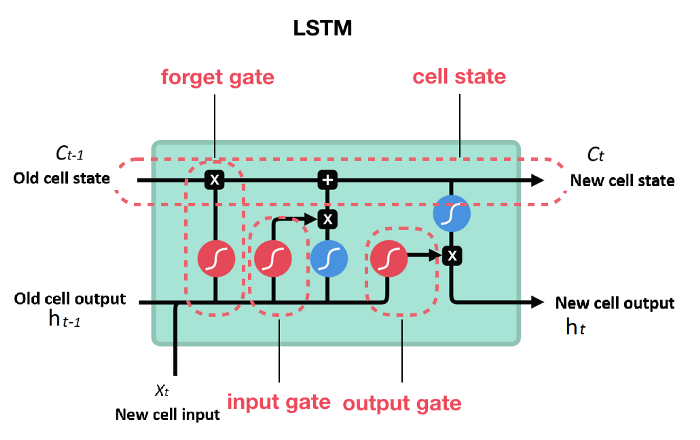

Fonte: https://pathmind.com/wiki/lstm#recurrent

<p>As redes LSTM e as RNN em geral foram desenvolvidas para lidar com dados sequênciais, como por exemplo: Séries Temporais, Áudio, Sequências de palavras, etc.</p>
<p>Em suma, essa família de redes usam funções matemáticas que mapeiam o valor de saída atual baseado nos valores de saída passados.</p>

#### Construção da LSTM

<p>Para implementarmos nossa LSTM vamos utilizar os dados de movimentações da <i>Apple</i> (ticker: APPL).</p>
<p>Os dados podem ser encontrados no <i>Kaggle</i>.</p>

In [1]:
  #Bibliotecas para manipulação dos dados
    import pandas as pd
    import numpy as np
    from datetime import datetime
    
    #Bibliotecas de gráfico
    import matplotlib.pyplot as plt
    %matplotlib inline
    from matplotlib.pylab import rcParams
    rcParams['figure.figsize']=20,10
    plt.style.use('ggplot')
    
    #Bibliotecas para construímos a LSTM
    from keras.models import Sequential
    from keras.layers import LSTM,Dropout,Dense,LeakyReLU
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    
    #Biblioteca para retirar avisos
    import warnings
    warnings.filterwarnings("ignore")

#### Tratamento de Dados

In [2]:
#Leitura dos dados
dados=pd.read_csv("Apple_stocks.csv",sep=",")

In [3]:
#Conhecendo os dados que iremos trabalhar
dados.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


In [4]:
dados.dtypes

Date           object
 Close/Last    object
 Volume         int64
 Open          object
 High          object
 Low           object
dtype: object

<p> Podemos observar que nossos dados não estão em um formato que podem ser utilizados em uma LSTM, pois por padrão as sequências de dados de <i>input</i> devem ser numéricos.</p>
<p>Além disso, a coluna <i>Date</i> está com um formato diferente do desejável para construírmos nossa Série Temporal.<p>


In [5]:
#Vamos criar uma cópia dos dados originais para podermos manipular os dados.
df = dados.copy()

In [6]:
#Renomeando as colunas
df.columns = ["Date","Close","Volume","Open","High","Low"]

O objetivo da nossa LSTM vai ser prever o preço de fechamento da ação, com isso precisamos transformar os dados da coluna <i><b>Close</b></i> de <i>object</i> para <i>float</i>.

In [7]:
#Definindo a função para alteramos as datas
def to_string_date(x:str):
    return pd.to_datetime(
                datetime.strftime(
                      datetime.strptime(x.replace("/","-"),"%m-%d-%Y"),"%Y-%m-%d"))

In [8]:
#Definindo a função para alteramos o valor de fechamento
def to_float(x:str):
    return float(x[x.find("$")+1:])

In [9]:
#Aplicamos as funções nas colunas que precisam de transformação
df["Date"] = df["Date"].apply(to_string_date)
df["Close"] = df["Close"].apply(to_float)
df = df.sort_values('Date')

In [10]:
#Visualização dos dados após alteração
df.head()

,Date,Close,Volume,Open,High,Low
2517,2010-03-01,29.8557,137312041,$29.3928,$29.9286,$29.35
2516,2010-03-02,29.8357,141486282,$29.99,$30.1186,$29.6771
2515,2010-03-03,29.9043,92846488,$29.8486,$29.9814,$29.7057
2514,2010-03-04,30.1014,89591907,$29.8971,$30.1314,$29.8043
2513,2010-03-05,31.2786,224647427,$30.7057,$31.3857,$30.6614


<p>Agora que fizemos o tratamento das colunas que iremos utilizar, precisamos colocar nossos dados no formato de uma Série Temporal.</p>


In [11]:
df.index = df["Date"]
df = df["Close"]

<p>Após criada nossa Série, vamos fazer um plot dos dados.</p>

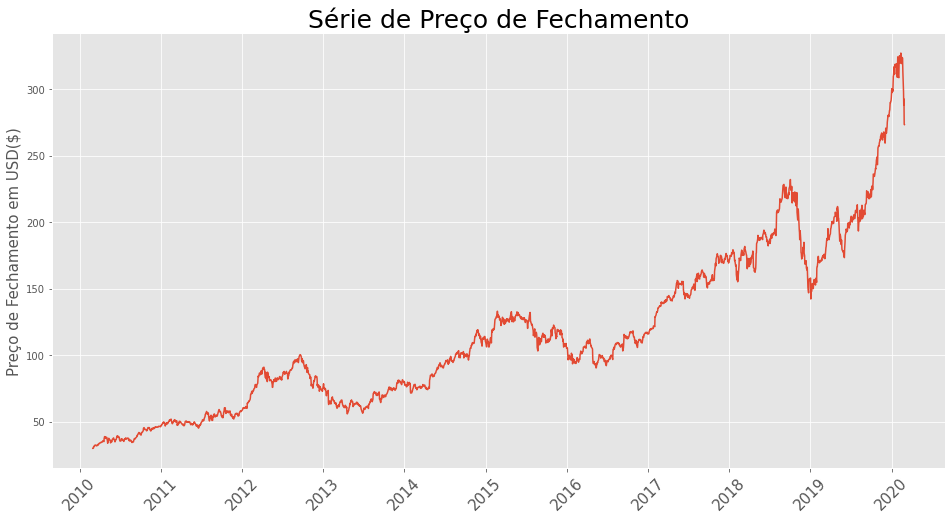

In [12]:
#Vamos analisar o comportamento da nossa variável resposta
plt.figure(figsize=(16,8))
plt.ylabel("Preço de Fechamento em USD($)",fontsize=15)
plt.title('Série de Preço de Fechamento',fontsize=25)
plt.xticks(rotation= 45,fontsize=15)
plt.plot(df)

<p>Ao analisarmos o gráfico podemos perceber uma tedência na nossa série, além de uma grande discrepância entre os valores observados. </p>
<p>Para solucionarmos o problema da diferença entre os valores, vamos usar uma técnica de normalização.</p>

In [13]:
dataset = df.values.reshape((-1,1))
scaler = MinMaxScaler(feature_range=(0, 1)) 
dataset = scaler.fit_transform(dataset)

<p>Antes de iniciarmos o processo de modelagem propriamente dito, temos que decidir quantas observações do passado vamos utilizar para estimarmos o valor futuro.</p>
<p>Além disso, temos que decidir quantos passos à frente vamos querer estimar.</p>

In [14]:
'''Para treinar nossa rede, usaremos um intervalo de tempo para prevermos o nosso próximo valor'''
look_back = 5
future_target = 1

<p>Então, seguindo o processo de modelagem, vamos separar nossos dados em dados de treino e teste. Nesse caso, vamos usar 70% dos dados como dados de teste.</p>

In [15]:
'''Separando os dados em treino e teste.'''
tam = int(len(dataset) * 0.70)
dataset_teste = dataset[tam:]
dataset_treino = dataset[:tam]

<p>Por padrão, Redes Neurais necessitam que os dados de <i>input</i> estejam na forma matricial, de preferência uma matriz tridimensional.<p>

In [16]:
#Função de transformação dos dados
def process_data(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)


In [17]:
X, y = process_data(dataset_treino,look_back,future_target)
y = np.array([list(a.ravel()) for a in y])

x_test, y_test = process_data(dataset_teste,look_back,future_target)
y_test = np.array([list(a.ravel()) for a in y_test])

<p>Realizamos esse processo para permitir que a rede possa identificar que cada conjunto de valores de X_train gere o valor de y_train, ou seja, o input x_train[0] gera o output y_train[0] e assim sussecivamente.<p>

In [18]:
X[0]

array([[6.72575693e-05],
       [0.00000000e+00],
       [2.30693463e-04],
       [8.93516807e-04],
       [4.85229733e-03]])

In [19]:
y[0]

array([0.00491451])

<p>Agora, vamos separar nosso conjunto de dados de teste e separar um porcentagem para validação.</p>

In [20]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

<p>No próximo passo vamos contruir a rede neural propriamente dita.</p>
<p>Iremos usar alguns paramêtros padrões, pois o processo de tunning dos parâmetros é um processo que exige testes e investigações mais profundas sobre os dados.</p>

In [21]:
#Definindo os números de neurônios por camada
n_first = 128
EPOCHS = 50
#Construido o modelo
model = Sequential()
model.add(LSTM(n_first,input_shape = (look_back,1)))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=False,batch_size=2, verbose=2)

Epoch 1/50
703/703 - 4s - loss: 8.5743e-04 - val_loss: 6.2867e-05
Epoch 2/50
703/703 - 4s - loss: 2.8878e-04 - val_loss: 6.3405e-05
Epoch 3/50
703/703 - 4s - loss: 2.2557e-04 - val_loss: 6.8523e-05
Epoch 4/50
703/703 - 4s - loss: 2.0397e-04 - val_loss: 2.0730e-04
Epoch 5/50
703/703 - 4s - loss: 1.9669e-04 - val_loss: 2.0154e-04
Epoch 6/50
703/703 - 4s - loss: 1.6453e-04 - val_loss: 1.4925e-04
Epoch 7/50
703/703 - 4s - loss: 1.5704e-04 - val_loss: 1.2235e-04
Epoch 8/50
703/703 - 4s - loss: 1.5750e-04 - val_loss: 1.1723e-04
Epoch 9/50
703/703 - 4s - loss: 1.3762e-04 - val_loss: 1.1777e-04
Epoch 10/50
703/703 - 4s - loss: 1.5352e-04 - val_loss: 1.0391e-04
Epoch 11/50
703/703 - 4s - loss: 1.4625e-04 - val_loss: 8.2056e-05
Epoch 12/50
703/703 - 4s - loss: 1.4953e-04 - val_loss: 1.5830e-04
Epoch 13/50
703/703 - 4s - loss: 1.5440e-04 - val_loss: 9.4394e-05
Epoch 14/50
703/703 - 4s - loss: 1.4556e-04 - val_loss: 1.1231e-04
Epoch 15/50
703/703 - 4s - loss: 1.4257e-04 - val_loss: 1.3208e-04
Epoc

<p>Após o treinamento do nosso modelo, podemos verificar o comportamento da função custo nos dados de validação e nos dados de teste.</p>
<p>A análise do comportamento das curvas podem ser usados como indicador de <i>underfitting</i> ou <i>overfitting</i>.</p>

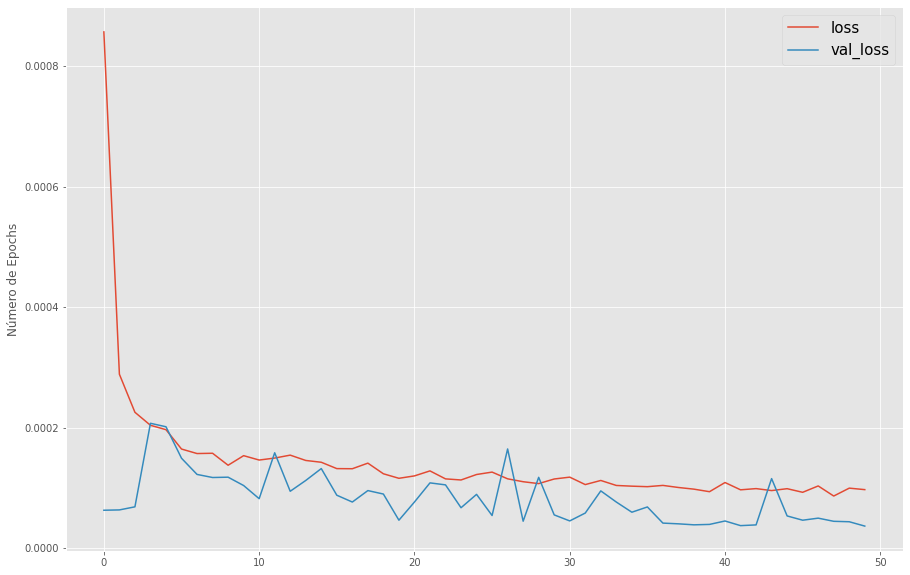

In [22]:
#Gráfico do resultado da função perda por epochs
plt.figure(figsize = (15,10))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel("Número de Epochs")
plt.legend(loc='best',fontsize=15)
plt.show()

<p>Em seguida, usamos nosso modelo escolhido para seguirmos para o processo de predição.</p>

In [23]:
#Salvando os valores preditos
Xt = model.predict(x_test)

<p>Por fim, podemos identificar o comportamento do nosso modelo na série.</p>
<p>Podemos observar que nosso modelo se comportou bem diante das configurações que escolhemos.</p>

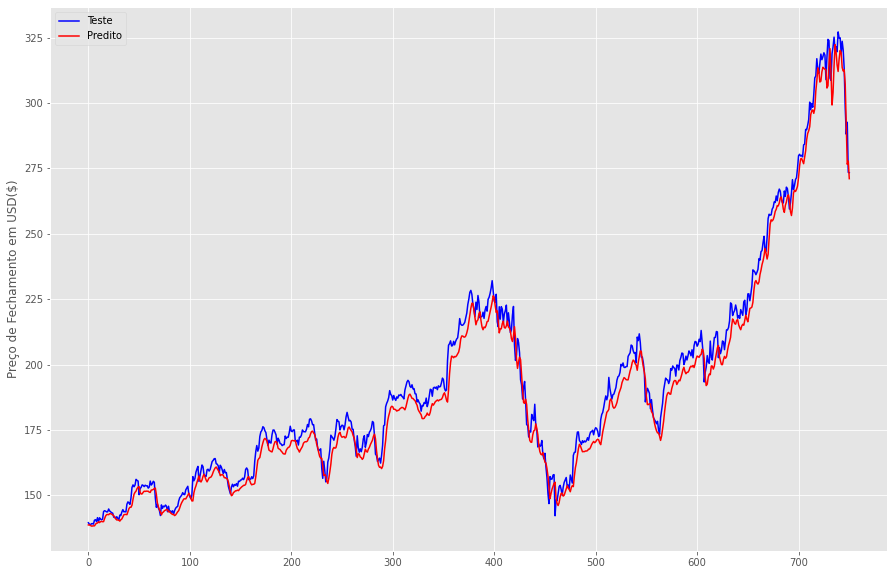

In [24]:
plt.figure(figsize = (15,10))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)),c='b', label='Teste')
plt.plot(scaler.inverse_transform(Xt.reshape(-1,1)), c='r',label='Predito')
plt.ylabel("Preço de Fechamento em USD($)")
plt.legend(loc='best')
plt.show()

#### Próximos passos

<p>Vimos que treinar uma Rede Neural não é uma tarefa de outro mundo, contudo exige conhecimento e prática para aperfeiçoar a rede.</p>
